### Emotion Detection project
- The object of this project is to classify emotions in real time.
- I used a pretrained resnet18 model from pytorch and finetuned using fer2013 dataset from kaggle.
- For the detection in real images (outside the set) and videos (real time), I use MTCNN for detecting the face to crop them out of the img and then I use the resnet for classification.


In [1]:
!pip install facenet_pytorch
!pip install transforms


     |████████████████████████████████| 1.9MB 17.7MB/s 
  Created wheel for transforms: filename=transforms-0.1-cp36-none-any.whl size=39351 sha256=88e6c0595aa611113b420be911fb7bda40e17564b65ae2f0d5a9266e7b0f43ac
  Stored in directory: /root/.cache/pip/wheels/9a/37/f1/418005fb3d7a7587348cde9f4e44b7df3b3b9f4f37977cc5e8
Successfully built transforms


In [129]:
import pandas as pd
import plotly.express as px
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import os
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from facenet_pytorch import MTCNN
import torch.nn.functional as F
import cv2
import numpy as np
import torch.nn.functional as F
from google.colab import drive
from sklearn.metrics import confusion_matrix
import seaborn as sns
import requests
from io import BytesIO

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [112]:
fre_data = pd.read_csv('/content/drive/My Drive/fer2013_data/fer2013.csv')

### Data Exploriation 

In [125]:
emotions = {0: 'Angry',1:'Disgust' ,2:'Fear',3:'Happy', 4:'Sad',5:'Surprise', 6:'Neutral' }
count_lab = fre_data.emotion.value_counts().reset_index().rename(columns={'index':'emotion_num','emotion':'count'})

In [126]:
count_lab['emotion'] = count_lab['emotion_num'].map(emotions)  

In [135]:
fre_data.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [151]:
fre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [130]:

fig = px.bar(x=count_lab['emotion'], y=count_lab['count'],
             labels=dict(x="emotion", y="# imgs"),title='fer2013 data dist')
fig.show()

It is clear that there is unbalancing in some classes espically disgust class

In [140]:
X_data = np.array(list(map(str.split, fre_data.pixels)), np.float32)
X_data = X_data.reshape(X_data.shape[0], 48, 48) 
y_data = list(fre_data.emotion) 




#### Sample from the fer2013 data 

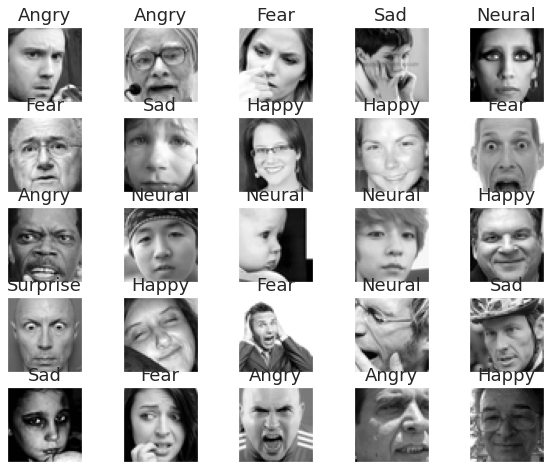

In [150]:
fig = plt.figure(figsize = (10,8))
for i in range(len(X_data[:25])):
    if(y_data[i] == 0 ):
        emotion = 'Angry'
        img = Image.fromarray(np.uint8(X_data[i]))
    elif(y_data[i] == 1):
        emotion = 'Disgust'
        img = Image.fromarray(np.uint8(X_data[i]))
    elif(y_data[i] == 2):
        emotion = 'Fear'
        img = Image.fromarray(np.uint8(X_data[i]))
    elif(y_data[i] == 3):
        emotion = 'Happy'
        img = Image.fromarray(np.uint8(X_data[i]))
    elif(y_data[i] == 4):
        emotion = 'Sad'
        img = Image.fromarray(np.uint8(X_data[i]))
    elif(y_data[i] == 5):
        emotion = 'Surprise'
        img = Image.fromarray(np.uint8(X_data[i]))
    elif(y_data[i] == 6):
        emotion = 'Neural'
        img = Image.fromarray(np.uint8(X_data[i]))
    y = fig.add_subplot(5,5,i+1)
    y.imshow(img,cmap='gray')
    plt.title(emotion)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

## Convert pixcel data to imgs 

In [14]:

def generate_img_from_file(filecsv):
    
    orig_data = pd.read_csv(filecsv)

    emotions = {0: 'angry',1:'disgust' ,2:'fear',3:'happy', 4:'sad',5:'Surprise', 6:'neutral' }
    dir = 'data_file'
    if(not os.path.isdir(dir)):
        os.mkdir(dir)

    length = len(orig_data)
    count = 0
    for i in range(length):
        count = count+1
        row = orig_data.iloc[i]
        array_pixs = np.fromstring(row.pixels, dtype=int, sep=' ').reshape(48,48)
        array_pixs = array_pixs.astype(np.float32)
        image = Image.fromarray(array_pixs).convert('RGB')
        label_emotion = emotions[row.emotion]
        emot_pa = os.path.join(dir, label_emotion)
        cwd = os.getcwd()
        if(not os.path.isdir(emot_pa)):
            os.mkdir(emot_pa)
        if (count % 1000 == 0):
            print(count)
        if (count ==35886):
            print('done')
        name = f'{label_emotion}_{i}.png'
        image.save(os.path.join(emot_pa, name))

generate_img_from_file('/content/drive/My Drive/fer2013_data/fer2013.csv')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
done


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [16]:
def loss_plot(epoch, val_loss,train_loss):
        #generate val/train loss plot
        list_of_ep = []
        for e in range(1,epoch+1):
            list_of_ep.append(e)
        plt.plot(list_of_ep, val_loss,label='Validation')
        plt.plot(list_of_ep, train_loss,label='Training')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [17]:
# For training 
def train():
        print('*********Training*********')
        model.train()
        accuracy_count = 0
        batch_count = 0
        count = 0
        loss_count = 0

        for data, labels in dataloader_training:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            preds = torch.argmax(output, 1)
            acc = (preds == labels).sum().item()
            accuracy_count += acc
            loss_value = criterion(output, labels)
            loss_count += loss_value.item()
            batch_count += len(labels)

            count += 1
          
            loss_value.backward()
            optimizer.step()
            if(count % 100 == 0):
                 accuracy_res = accuracy_count/batch_count
                 loss_res = loss_count/count
                 print(f'Accuracy: {round(accuracy_res, 3)} \t Loss: {round(loss_res,3)}')
                
        return loss_count/count

In [18]:
# For validation
def test():
        print('*********Validation*********')
        model.eval()
        accuracy_count = 0
        batch_count = 0
        count = 0
        loss_count = 0
        correct_label = [0 for i in range(len(class_names))]
        total_label = [0 for i in range(len(class_names))]

        with torch.no_grad():

            for data, labels in dataloader_testing:
                
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss_c = criterion(outputs, labels)
                predict = torch.argmax(outputs, 1)
                accuracy = (predict == labels).sum().item()
                c = (predict == labels)

            for l in range(len(labels)):
                label = labels[l]
                correct_label[label] += c[l].item()
                total_label[label] += 1

            accuracy_count += accuracy
            loss_count += loss_c.item()
            batch_count += len(labels)
            count += 1

        accuracy = accuracy_count/batch_count
        loss_value = loss_count/count
        print(f'Accuracy: {round(accuracy, 3)} \t Loss: {round(loss_value, 3)}')
        print('---------------------------------------------------------------')
        return round(loss_count/count, 4)



Finetune a pretrained resnet18 (trained on imgnet dataset) model 

In [19]:
# Constructing Dataloaders 
dir = 'data_file'
transform = transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
full_dataset = datasets.ImageFolder(dir, transform)
loss_train_all = []
loss_val_all = []
#train-test split
train_length = int(0.7 * len(full_dataset))
test_length = len(full_dataset) - train_length
training_data, testing_data = torch.utils.data.random_split(full_dataset, [train_length, test_length])

#dataloaders
dataloader_training = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True)
dataloader_testing = torch.utils.data.DataLoader(testing_data, batch_size=128, shuffle=True)
#labels
class_names = full_dataset.classes
num_classes = len(class_names)

#resnet model initialize 
model = models.resnet18(pretrained=True)
features_count = model.fc.in_features
model.fc = nn.Linear(features_count, num_classes)
model = model.to(device) 
#hyperparameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
EPOCH_SIZE = 50

for epoch in range(EPOCH_SIZE):
    print(f'EPOCH {epoch} OUT OF {EPOCH_SIZE}')
    train_loss = train()
    validation_loss = test()
    loss_train_all.append(train_loss)
    loss_val_all.append(validation_loss)
    exp_lr_scheduler.step()

loss_plot(EPOCH_SIZE, loss_val_all,loss_train_all)
torch.save(model, 'model_2.pt')


In [23]:
# prediction
model.eval()
accuracy_count = 0
count = 0
correct_label = [0 for i in range(len(class_names))]
total_label = [0 for i in range(len(class_names))]
all_labels = []
all_results = []
with torch.no_grad():

    for data, labels in dataloader_testing:
                
          data, labels = data.to(device), labels.to(device)
          outputs = model(data)
          all_labels.append(labels)
          preds = torch.argmax(outputs, 1)
          all_results.append(preds)
          accuracy = (preds == labels).sum().item()
          c = (preds == labels)

    for l in range(len(labels)):
          label = labels[l]
          correct_label[label] += c[l].item()
          total_label[label] += 1

    accuracy_count += accuracy
    count += 1


In [24]:
predections = []
for i in range(0,len(all_results)):
    predections.extend(all_results[i].tolist())

In [25]:
true_labels = []
for i in range(0,len(all_labels)):
    true_labels.extend(all_labels[i].tolist())

In [44]:
count =0
for i,j in zip(predections,true_labels):
  if (predections[i]==true_labels[j]):
    count = count+1
print("accuracy = {}".format(count/len(true_labels)))

accuracy = 0.814618742453794


Model accuracy is ~81 however it is important to examine the confusion matrix since the data is unbalanced

[Text(58.5, 0.5, 'True label'), Text(0.5, 58.5, 'Predicted label')]

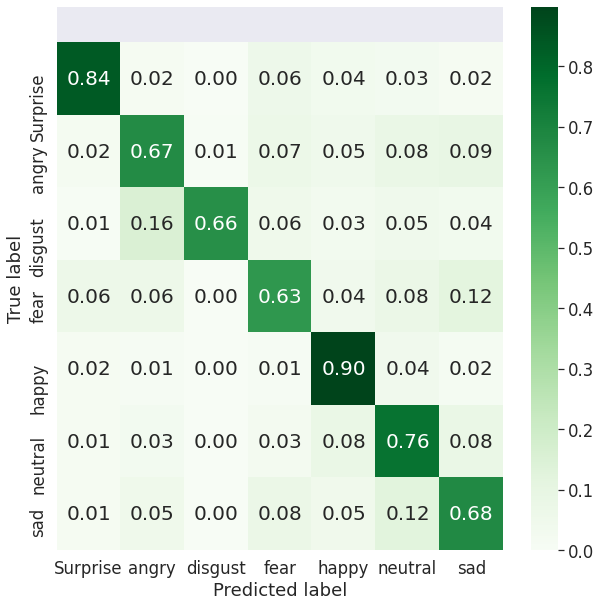

In [26]:

cm = confusion_matrix(true_labels, predections)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, cmap="Greens", 
                yticklabels=full_dataset.classes, xticklabels=full_dataset.classes, vmin=0, 
                vmax=np.max(cm_normalised), fmt=".2f", annot_kws={"size":20})
ax.set_ylim(7.5-0.5, -0.5)


ax.set(xlabel='Predicted label', ylabel="True label")

The classification for classes happy, neutral, and surpeise is good.
however, in other classes the model is mixing between some of them for example angry and digust; also fear and sad. 
- This might be because the number of samples in these classes is much less than the others 
- Also, looking at some images. It can be observed that some experssion can be mixed up like disgust and angry/sad and neutral
- In addition, experimenting with a bigger structure might lead to better results

## Prediction examples out of the fer2013 data

To detect the faces  --> use MTCNN 

In [52]:
colors = {
    'angry': (225,33,33),#red
    'disgust':(225,33,144),#pink
    'fear': (64,55,128), #purple
    'happy': (84,183,84),#green
    'sad': (24,31,49), #black
    'Surprise': (190,208,75),#yellow
    'neutral': (26,210,192),#blue 
  }
class_names = [ 'Surprise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


In [107]:
req = requests.get("https://github.com/googlefonts/roboto/blob/master/src/hinted/Roboto-Regular.ttf?raw=true")
font = ImageFont.truetype(BytesIO(req.content), size=32)

In [97]:
def crop_img(boxes,image):
     crop_image = image.crop(boxes)
     transform = transforms.Compose([transforms.Resize((224,224),interpolation=Image.NEAREST),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
     tensor = transform(crop_image)
     tensor = tensor.to(device)
     return tensor

In [108]:



def predict(image):
    """Predicting emotions"""
    model.eval()
    mtcnn = MTCNN(keep_all=True)
    boxes_t = mtcnn.detect(image)
    correct_boxes = []
    for index, probability in enumerate(boxes_t[1]):
        if(probability > 0.95):
              correct_boxes.append(boxes_t[0][index])

    for boxes in correct_boxes:
        tensor = crop_img(boxes,image)
        with torch.no_grad():
            predection = F.softmax(model(tensor.view(-1, 3, 224, 224))).squeeze()

        probability_emotion = predection[torch.argmax(predection).item()].item()
        predicted = class_names[torch.argmax(predection)]
        emotion_color = colors[predicted]

        left, top, right, bottom = boxes
        x, y = left+2.5, bottom+2.5

        text = f'{predicted} {round(probability_emotion, 2)}'
        w, h = font.getsize(text)

        draw = ImageDraw.Draw(img)
        draw.rectangle(boxes, outline=emotion_color)
        draw.rectangle((x-5,y-2.5,x+w+5,y+h+2.5), fill=emotion_color)
        draw.text((x,y), text, font=font, fill=(255,255,255))
        
  
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


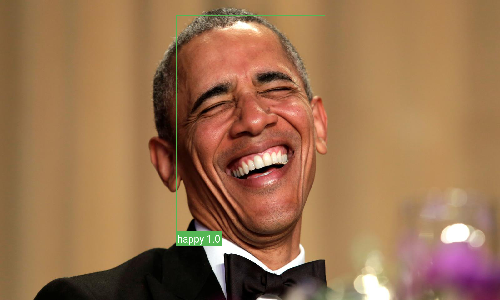

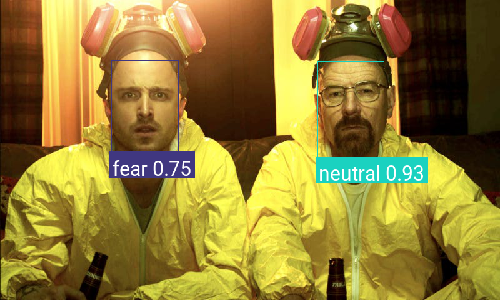

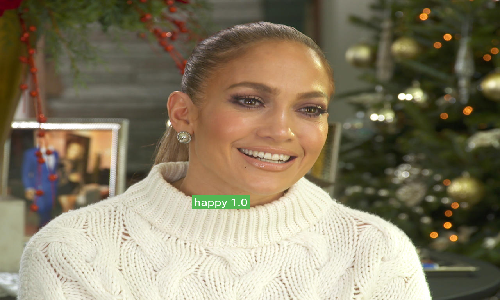

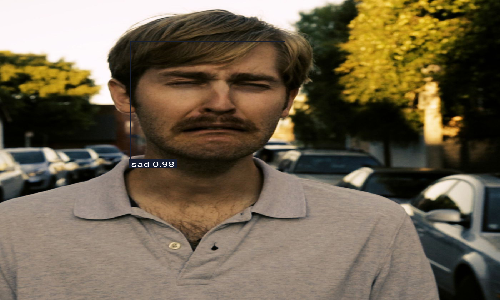

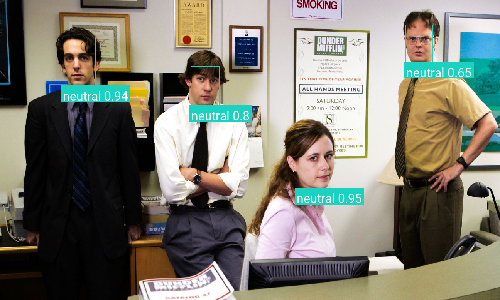

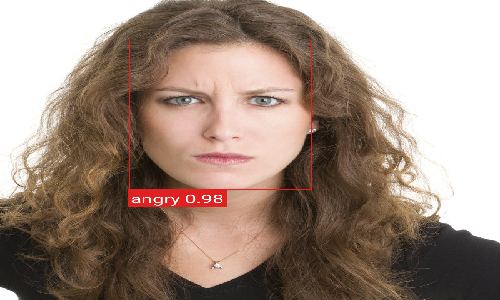

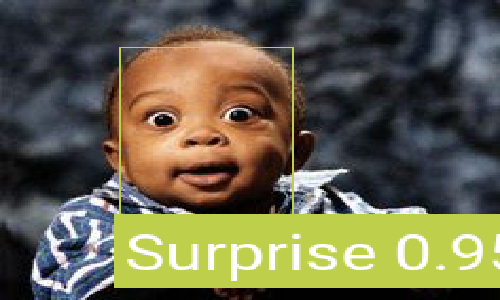

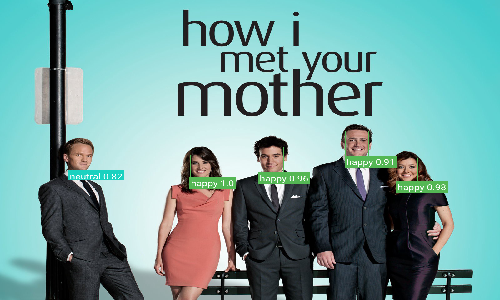

In [110]:
testing_dir = '/content/drive/My Drive/fer2013_data/testing'
for img_n in os.listdir(testing_dir):
    path = os.path.join(testing_dir, img_n)
    img = Image.open(path).convert('RGB')
    predict(img)
    display(img.resize((500, 300), Image.NEAREST))


In [ ]:
# Real time emotion detection using MTCNN for face detection and trained resnet for classification.

class Emotiondetection(object):

    def __init__(self, mtcnn):
        # face detection model
        self.mtcnn = mtcnn
        # Load the model
        self.trained_model =torch.load("model_2.pt"))
        self.trained_model.eval()
        

    def _draw(self, frame, boxes, probs, landmarks):
        """
        Draw boxes 
        """
        try:

            class_names = [ 'Surprise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
            emotion_color_dict = {
                'angry': (225,33,33),#red
                'disgust':(225,33,144),#pink
                'fear': (64,55,128), #purple
                'happy': (84,183,84),#green
                'sad': (24,31,49), #black
                'Surprise': (190,208,75),#yellow
                'neutral': (26,210,192),#blue 
              }

            for box, prob, ld in zip(boxes, probs, landmarks):
                # Draw rectangle
                # MTCNN detect landmarks too however there is no need for it with this application
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                im_pil = Image.fromarray(img)
                img_cropped = im_pil.crop(box)
                transform = transforms.Compose([transforms.Resize((224,224),interpolation=Image.NEAREST),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                img_tensor = transform(img_cropped)

                with torch.no_grad():
                        output = F.softmax(self.trained_model(img_tensor.view(-1, 3, 224, 224))).squeeze()
                #predict emotion
                prob_emotion = output[torch.argmax(output).item()].item()
                pred_emotion = class_names[torch.argmax(output)]
                emotion_color = emotion_color_dict[pred_emotion]
                emotion_text = f'{pred_emotion} {round(prob_emotion, 2)}'
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (emotion_color),
                              thickness=2)
                
                cv2.putText(frame, str(
                    pred_emotion), (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, emotion_color, 2, cv2.LINE_AA)


        except:
            pass

        return frame

    def run(self):
        # strat camera
        cap = cv2.VideoCapture(0)
        #for every fra,e check for faces then run draw method
        while True:
            ret, frame = cap.read()
            try:
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                # draw on frame
                self._draw(frame, boxes, probs, landmarks)


            except:
                pass

            cv2.imshow('Face Detection', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        
        
mtcnn = MTCNN()
ed = Emotiondetection(mtcnn)
ed.run()